<a href="https://colab.research.google.com/github/M7mdNassar/PlantieMLModelRepo/blob/main/Plantie_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Aim: Plant Disease Classification Model***

Configure Working Environment :

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
from PIL import Image
import shutil
import random
import glob as gb
import cv2
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy , CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint


Mount Google Drive :




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Declare Paths :

In [ ]:
# Define paths
dataset = '/content/drive/MyDrive/PSDMachineLearning/PlantieDataset_800'
train_folder = '/content/drive/MyDrive/PSDMachineLearning/train'
test_folder = '/content/drive/MyDrive/PSDMachineLearning/test'
checkpoint_path = '/content/drive/MyDrive/PSDMachineLearning/best_model_checkpoint.h5'


This Cells Just Do It One Time Only (Resize images to (224 , 224))

In [ ]:
# Function to resize images
def resize_image(input_path, output_path, target_size):
    img = Image.open(input_path)
    img_resized = img.resize(target_size, Image.ANTIALIAS)
    img_resized.save(output_path)

In [ ]:
# Resize images in the dataset folder
input_folder = '/content/drive/MyDrive/PSDMachineLearning/PlantieDataset_800'
output_folder = '/content/drive/MyDrive/PSDMachineLearning/resized_plantieDataset'
os.makedirs(output_folder, exist_ok=True)


In [ ]:
from PIL import Image
import os

def resize_image(input_path, output_path, target_size):
    img = Image.open(input_path)
    img_resized = img.resize(target_size, Image.Resampling.LANCZOS)  # Updated to LANCZOS
    img_resized.save(output_path)

target_size = (224, 224)  # Target size for resizing

# Process images
for class_folder in os.listdir(input_folder):
    if class_folder.startswith('.'):  # Skip hidden files/folders
        continue

    class_path = os.path.join(input_folder, class_folder)
    output_class_path = os.path.join(output_folder, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    for image_file in os.listdir(class_path):
        if image_file.startswith('.'):  # Skip hidden files
            continue

        input_image_path = os.path.join(class_path, image_file)
        output_image_path = os.path.join(output_class_path, image_file)

        # Resize the image and save it to the output folder
        resize_image(input_image_path, output_image_path, target_size)

print("Images successfully resized.")


Images successfully resized.


# ***Spliting*** (80% of Dataset for Training , and the remain for Testing (20%))

In [ ]:
# Split dataset into train and test sets
split_ratio = 0.8

for class_folder in os.listdir("/content/drive/MyDrive/PSDMachineLearning/resized_plantieDataset"):
    if class_folder.startswith('.'):  # Skip hidden files/folders
        continue

    class_path = os.path.join("/content/drive/MyDrive/PSDMachineLearning/resized_plantieDataset", class_folder)
    train_class_path = os.path.join(train_folder, class_folder)
    test_class_path = os.path.join(test_folder, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    images = os.listdir(class_path)
    random.shuffle(images)

    train_count = int(len(images) * split_ratio)
    train_images = images[:train_count]
    test_images = images[train_count:]

    for image in train_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(train_class_path, image)
        shutil.copyfile(src, dst)

    for image in test_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(test_class_path, image)
        shutil.copyfile(src, dst)

print("Dataset successfully split into train and test sets.")

Dataset successfully split into train and test sets.


# ***Analysis Data***



Total images in all classes:

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle = True,
    image_size = (224 , 224),
    batch_size = 32
)


Found 23707 files belonging to 37 classes.


Labels :

In [ ]:
class_names = train_ds.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Bean___angular_leaf_spot',
 'Bean___healthy',
 'Bean___rust',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Cucumber___Anthracnose',
 'Cucumber___Gummy Stem Blight',
 'Cucumber___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Pepper_bell___Bacterial_spot',
 'Pepper_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'olive_aculus_olearius',
 'olive_healthy',
 'olive_peacock_spot']

Shape of the data(the image)

In [ ]:
for image_batch , label_batch in train_ds.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 224, 224, 3)
[13 18 13  5 13 28  2 25  9 28  1 29  1 19 23 36  2  8 19 16  5 29 36 36
 18 26 13 28 17 19 23 17]


Display some images with there labels from the train dataset:

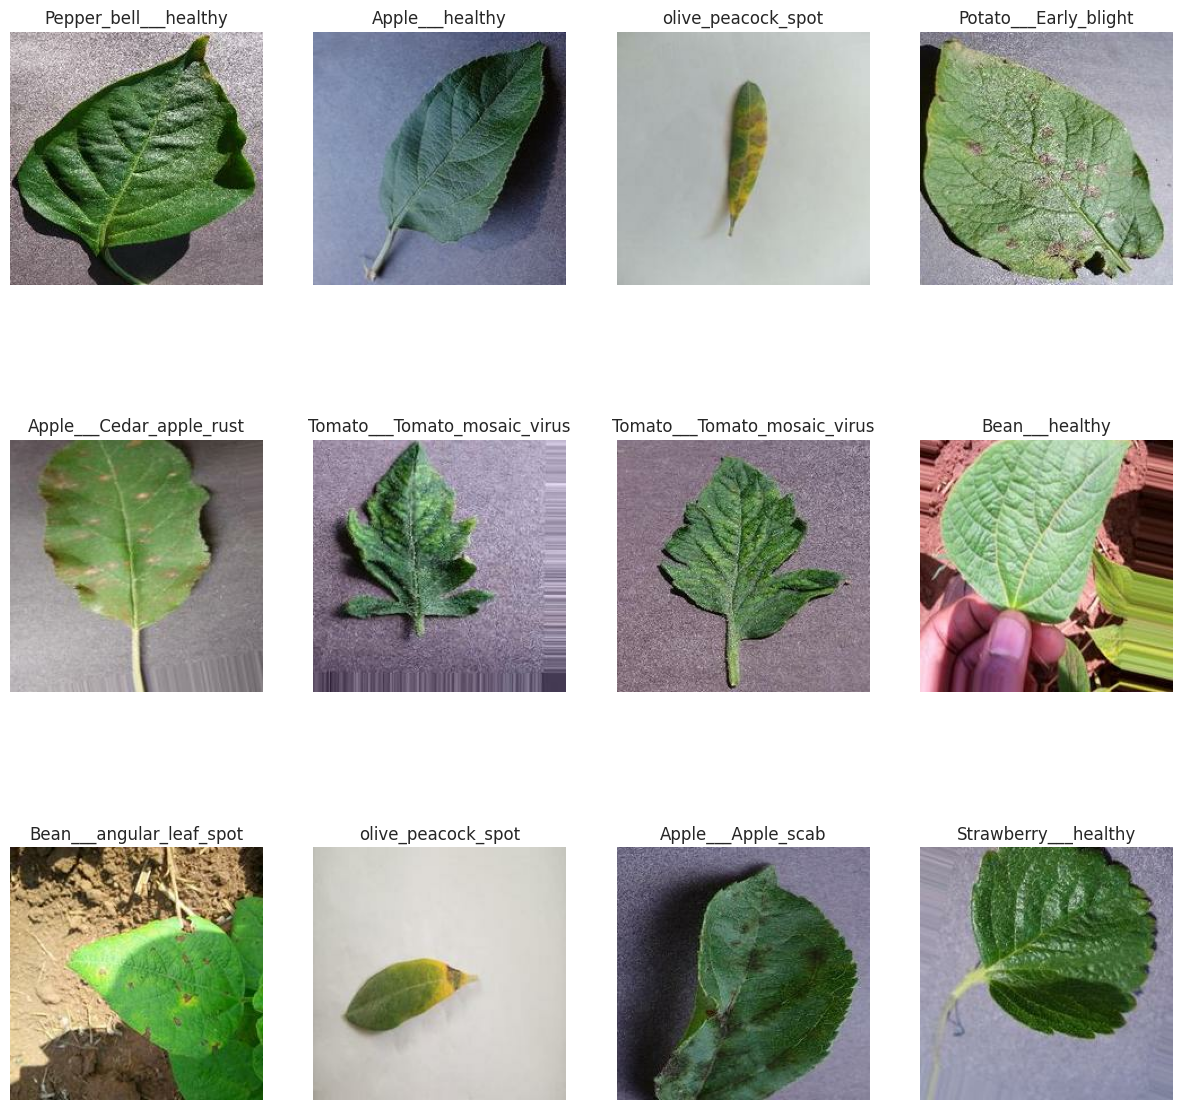

In [ ]:
plt.figure(figsize = (15,15))
for image_batch , label_batch in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Number of images in each class from Train and Test folders:

In [ ]:
# Print class names and number of images in train folder
print("Train Folder:")
for class_folder in os.listdir(train_folder):
    class_path = os.path.join(train_folder, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_folder}: {num_images} images")

# Print class names and number of images in test folder
print("\nTest Folder:")
for class_folder in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_folder}: {num_images} images")

Train Folder:
Tomato___Target_Spot: 640 images
Grape___Black_rot: 640 images
Cucumber___healthy: 624 images
Potato___Early_blight: 640 images
Bean___rust: 640 images
Potato___Late_blight: 639 images
olive_healthy: 638 images
Tomato___Late_blight: 639 images
Strawberry___healthy: 640 images
Bean___angular_leaf_spot: 640 images
Tomato___healthy: 652 images
Tomato___Leaf_Mold: 639 images
Tomato___Tomato_mosaic_virus: 640 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 640 images
Grape___Esca_(Black_Measles): 640 images
Grape___healthy: 640 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 640 images
Apple___Cedar_apple_rust: 640 images
Tomato___Early_blight: 640 images
Tomato___Bacterial_spot: 640 images
Apple___Apple_scab: 640 images
Pepper_bell___healthy: 669 images
Corn___Common_rust: 640 images
Tomato___Spider_mites Two-spotted_spider_mite: 640 images
Tomato___Septoria_leaf_spot: 640 images
olive_aculus_olearius: 640 images
Corn___Northern_Leaf_Blight: 639 images
Bean___healthy: 6

**Summary about the Data:**


*   Our Data seem Balanced , Good!!
*   All images size is 224,224 .
*   The images in RGB (3 channels) .
*   We have 37 classes (disease) for 10 plants exactly.
*   In Train folder we have 23707 images.
*   In Test folder we have 5932 images.



# **Now Configure Environment For Training**

Split Train folder into 80% for training , 20% for validation :

---



In [ ]:
# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

# Create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

# Print dataset information
print("Train Dataset:")
print(train_ds.class_names)
print(train_ds.element_spec)
print("\nValidation Dataset:")
print(val_ds.class_names)
print(val_ds.element_spec)
print("\nTest Dataset:")
print(test_ds.class_names)
print(test_ds.element_spec)

Found 23707 files belonging to 37 classes.
Using 18966 files for training.
Found 23707 files belonging to 37 classes.
Using 4741 files for validation.
Found 5932 files belonging to 37 classes.
Train Dataset:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Bean___angular_leaf_spot', 'Bean___healthy', 'Bean___rust', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Cucumber___Anthracnose', 'Cucumber___Gummy Stem Blight', 'Cucumber___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Pepper_bell___Bacterial_spot', 'Pepper_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_m

One-hot encoding for (train_ds , val_ds , test_ds) :

In [ ]:
# One-hot encode the labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=37)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=37)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=37)))

Prefetch :

In [ ]:
# Prefetch data
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Declare Model Hyperparameters:

In [ ]:
# Define model hyperparameters
IMG_SHAPE = (224, 224, 3)
LOSS = CategoricalCrossentropy()
OPTIMIZER = Adam(learning_rate=0.001)
BATCH_SIZE = 32

Define CallBacks function:

In [ ]:
def get_callbacks(model_name):
    callbacks = []
    checkpoint = ModelCheckpoint(filepath=f'/content/drive/MyDrive/PSDMachineLearning/check_points/model_{model_name}.keras',
                                  monitor='val_loss',
                                  save_best_only=True,
                                  mode='min',
                                  verbose=1)
    callbacks.append(checkpoint)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  min_lr=0.0000001,
                                  min_delta=0.00001,
                                  mode='auto',
                                  verbose=1)
    callbacks.append(reduce_lr)

    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   verbose=1)
    callbacks.append(early_stopping)

    return callbacks



Initialise callbacks variable:

In [ ]:
# Define callbacks
callbacks = get_callbacks('mobilenetv2')

Data Augmentation using MobileNetV2 preprocessing function:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Lambda(preprocess_input)
])


Apply data augmentation to training , validation , testing datasets :

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))
test_ds = test_ds.map(lambda x, y: (data_augmentation(x), y))

# **MobileNetV2 Model**

In [ ]:
def create_model():
    base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(37, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])
    return model

In [ ]:
# Create and compile the model
model = create_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Start Trining the Model**

In [ ]:
# Train the model
total_epochs = 20


# Train the model
history = model.fit(train_ds, epochs=total_epochs,
                    validation_data=val_ds, callbacks=callbacks)




Epoch 1/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6716 - loss: 1.1051
Epoch 1: val_loss improved from inf to 15.75927, saving model to /content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 474s 705ms/step - accuracy: 0.6718 - loss: 1.1045 - val_accuracy: 0.0943 - val_loss: 15.7593 - learning_rate: 0.0010
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.8735 - loss: 0.3798
Epoch 2: val_loss improved from 15.75927 to 10.13604, saving model to /content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 395s 665ms/step - accuracy: 0.8735 - loss: 0.3797 - val_accuracy: 0.1888 - val_loss: 10.1360 - learning_rate: 0.0010
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9010 - loss: 0.2951
Epoch 3: val_loss did not improve from 10.13604
593/593 ━━━━━━━━━━━━━━━━━━━━ 423s 633ms/step - accuracy: 0.9010 - loss: 0.2951 - val_accuracy: 0.1848 -

# **Resume Training**

In [ ]:
# Train the model
total_epochs = 25

history = model.fit(train_ds, epochs=total_epochs,
                                initial_epoch=20,
                                validation_data=val_ds, callbacks=callbacks)


Epoch 21/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9729 - loss: 0.0863
Epoch 21: val_loss did not improve from 0.60724
593/593 ━━━━━━━━━━━━━━━━━━━━ 363s 611ms/step - accuracy: 0.9729 - loss: 0.0862 - val_accuracy: 0.7627 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 22/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9678 - loss: 0.0987
Epoch 22: val_loss did not improve from 0.60724
593/593 ━━━━━━━━━━━━━━━━━━━━ 377s 635ms/step - accuracy: 0.9678 - loss: 0.0987 - val_accuracy: 0.8310 - val_loss: 0.7536 - learning_rate: 0.0010
Epoch 23/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9653 - loss: 0.1010
Epoch 23: val_loss improved from 0.60724 to 0.59647, saving model to /content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 372s 618ms/step - accuracy: 0.9653 - loss: 0.1010 - val_accuracy: 0.8547 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 24/25
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step

In [ ]:
# Train the model
total_epochs = 28

history = model.fit(train_ds, epochs=total_epochs,
                                initial_epoch=25,
                                validation_data=val_ds, callbacks=callbacks)

Epoch 26/28
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9714 - loss: 0.0849
Epoch 26: val_loss did not improve from 0.59647
593/593 ━━━━━━━━━━━━━━━━━━━━ 378s 636ms/step - accuracy: 0.9714 - loss: 0.0849 - val_accuracy: 0.7878 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 27/28
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9710 - loss: 0.0913
Epoch 27: val_loss did not improve from 0.59647
593/593 ━━━━━━━━━━━━━━━━━━━━ 366s 609ms/step - accuracy: 0.9710 - loss: 0.0913 - val_accuracy: 0.8068 - val_loss: 0.8641 - learning_rate: 0.0010
Epoch 28/28
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9746 - loss: 0.0724
Epoch 28: val_loss did not improve from 0.59647
593/593 ━━━━━━━━━━━━━━━━━━━━ 382s 611ms/step - accuracy: 0.9746 - loss: 0.0725 - val_accuracy: 0.7456 - val_loss: 1.3796 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 26.


In [ ]:
# Train the model
total_epochs = 30

history = model.fit(train_ds, epochs=total_epochs,
                                initial_epoch=28,
                                validation_data=val_ds, callbacks=callbacks)

Epoch 29/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9713 - loss: 0.0874
Epoch 29: val_loss improved from 0.59647 to 0.49344, saving model to /content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 367s 619ms/step - accuracy: 0.9713 - loss: 0.0874 - val_accuracy: 0.8831 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 30/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9776 - loss: 0.0698
Epoch 30: val_loss did not improve from 0.49344
593/593 ━━━━━━━━━━━━━━━━━━━━ 371s 626ms/step - accuracy: 0.9776 - loss: 0.0698 - val_accuracy: 0.8699 - val_loss: 0.4952 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 29.


In [ ]:
# Train the model
total_epochs = 32

history = model.fit(train_ds, epochs=total_epochs,
                                initial_epoch=30,
                                validation_data=val_ds, callbacks=callbacks)

Epoch 31/32
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9746 - loss: 0.0718
Epoch 31: val_loss did not improve from 0.49344
593/593 ━━━━━━━━━━━━━━━━━━━━ 376s 634ms/step - accuracy: 0.9746 - loss: 0.0718 - val_accuracy: 0.6973 - val_loss: 1.7011 - learning_rate: 0.0010
Epoch 32/32
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9715 - loss: 0.0910
Epoch 32: val_loss improved from 0.49344 to 0.31070, saving model to /content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 366s 616ms/step - accuracy: 0.9715 - loss: 0.0910 - val_accuracy: 0.9167 - val_loss: 0.3107 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 32.


In [ ]:
# Train the model
total_epochs = 65

history = model.fit(train_ds, epochs=total_epochs,
                                initial_epoch=32,
                                validation_data=val_ds, callbacks=callbacks)

Epoch 33/65
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9730 - loss: 0.0830 
Epoch 33: val_loss improved from inf to 0.32697, saving model to /content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras
593/593 ━━━━━━━━━━━━━━━━━━━━ 9657s 16s/step - accuracy: 0.9730 - loss: 0.0830 - val_accuracy: 0.9032 - val_loss: 0.3270 - learning_rate: 0.0010
Epoch 34/65
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9726 - loss: 0.0843
Epoch 34: val_loss did not improve from 0.32697
593/593 ━━━━━━━━━━━━━━━━━━━━ 417s 632ms/step - accuracy: 0.9727 - loss: 0.0842 - val_accuracy: 0.7789 - val_loss: 1.0118 - learning_rate: 0.0010
Epoch 35/65
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9762 - loss: 0.0708
Epoch 35: val_loss did not improve from 0.32697
593/593 ━━━━━━━━━━━━━━━━━━━━ 383s 634ms/step - accuracy: 0.9762 - loss: 0.0708 - val_accuracy: 0.6083 - val_loss: 3.3408 - learning_rate: 0.0010
Epoch 36/65
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - acc

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.keras")


Convert to from .keras to .h5

In [ ]:
from tensorflow.keras.models import load_model

# # Load the .keras model
# model = load_model('model_name.keras')

# Save the model as .h5
model.save('model_name.h5')


# **Evaluation**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2122s 11s/step - accuracy: 0.9911 - loss: 0.0326
Test Loss: 0.044810932129621506
Test Accuracy: 0.9887053370475769


**Visualisation:**


*   Train acc. Vs Validation acc.
*   Train loss Vs Validation loss.



In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Extract metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot the training history
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

# ***Classification Report***

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.h5')

In [ ]:
import numpy as np

# Get predictions on the test dataset
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

179/186 ━━━━━━━━━━━━━━━━━━━━ 3s 516ms/step

In [ ]:
# Get true labels from the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert one-hot encoded true labels to single-label format
true_labels_single = np.argmax(true_labels, axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels_single, y_pred, target_names=class_names)
print("Classification Report:\n", report)



Classification Report:
                                                precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.97      0.97       160
                            Apple___Black_rot       0.93      0.97      0.95       160
                     Apple___Cedar_apple_rust       0.99      0.96      0.97       160
                              Apple___healthy       0.93      0.97      0.95       160
                     Bean___angular_leaf_spot       0.99      0.66      0.79       160
                               Bean___healthy       0.92      0.99      0.95       160
                                  Bean___rust       0.62      0.98      0.76       160
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.88      0.92       160
                           Corn___Common_rust       1.00      0.82      0.90       160
                  Corn___Northern_Leaf_Blight       0.88      0.93      0.91       160
                  

# ***Confusion Matrix***

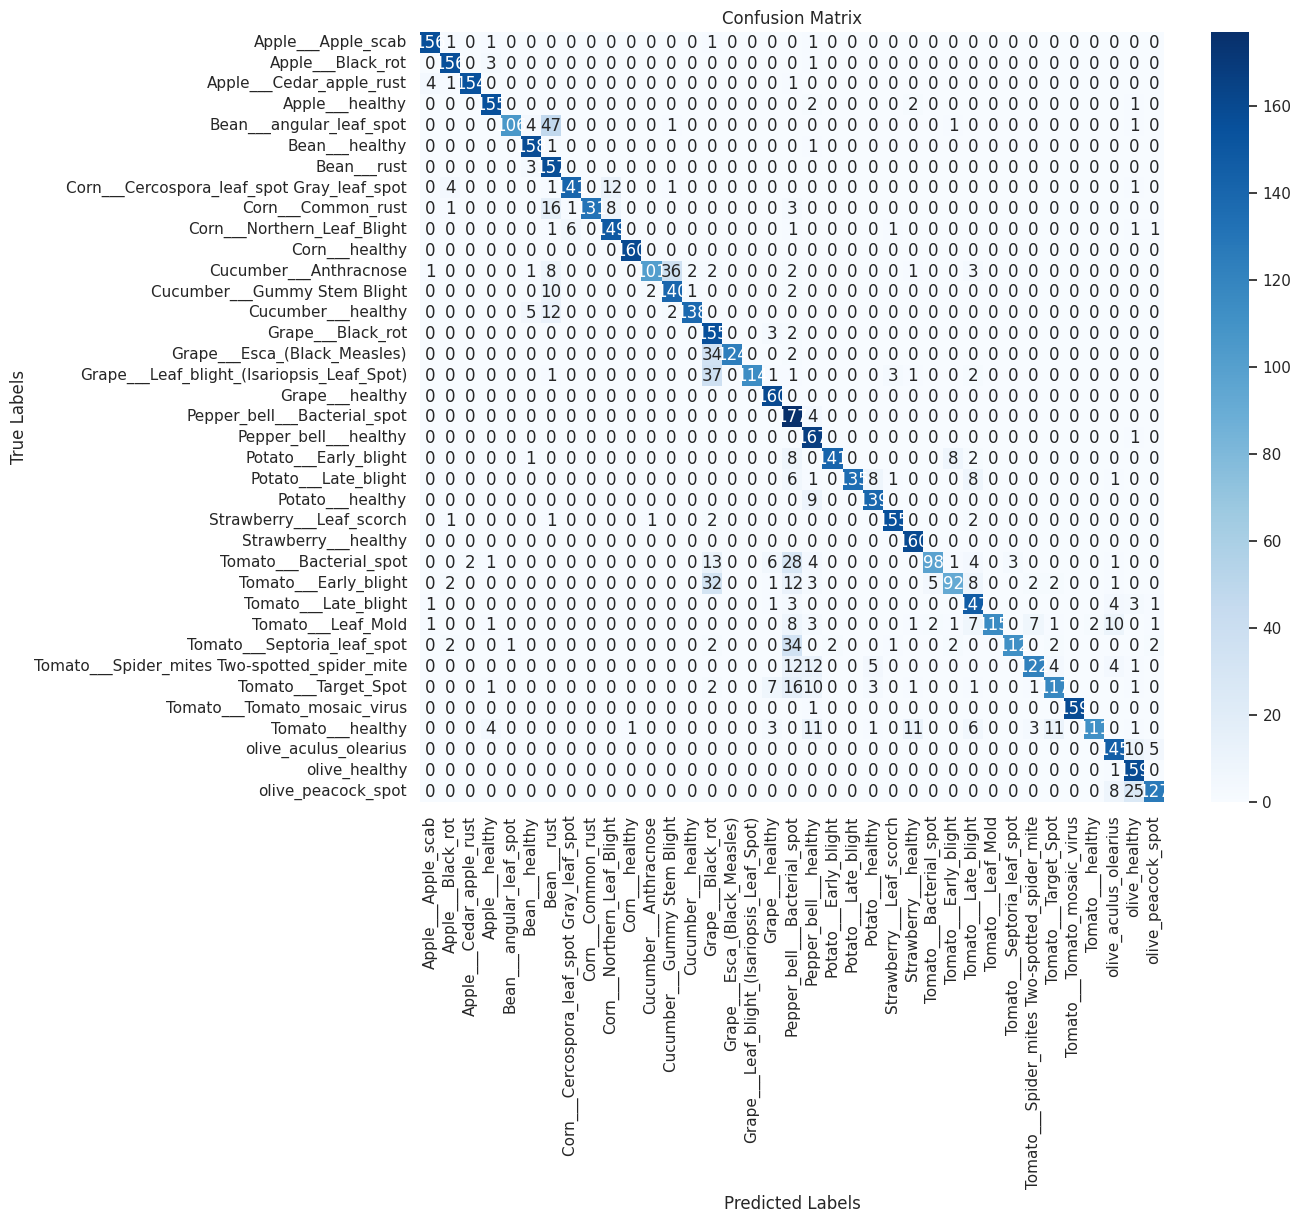

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_mat = confusion_matrix(true_labels_single, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# **Convert The Model**

CoreML

In [ ]:
!pip install coremltools

Load the Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.h5')


Convert To CoreML :

In [ ]:
from keras.models import load_model
import coremltools as ct
import tensorflow as tf
image_input = ct.ImageType()
f=open('/content/drive/MyDrive/MohammadNassar/labels-2.txt', "r")
contents = f.read().splitlines()
for i, label in enumerate(contents):
 if isinstance(label, bytes):
   contents[i] = label.decode("utf8")
classifier_config = ct.ClassifierConfig(contents)
image_input = ct.ImageType(shape=(1, 224, 224, 3,),bias=[-1,-1,-1], scale=1/127)
mlmodel = ct.convert(
   model,
   source="tensorflow",
   inputs=[image_input],
   classifier_config=classifier_config,
)
mlmodel.author = 'Mohammad Nassar'
mlmodel.short_description = 'Plant Disease Detection'
mlmodel.save('/content/drive/MyDrive/PSDMachineLearning/Plant.mlpackage')

# **Finaly, lets try the Model :)**

Load the model :

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the Keras model
model = load_model('/content/drive/MyDrive/PSDMachineLearning/check_points/model_mobilenetv2.h5')

Initialise class_names , if you not have this variable :

In [ ]:
class_names = ['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Bean___angular_leaf_spot',
 'Bean___healthy',
 'Bean___rust',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Cucumber___Anthracnose',
 'Cucumber___Gummy Stem Blight',
 'Cucumber___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Pepper_bell___Bacterial_spot',
 'Pepper_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'olive_aculus_olearius',
 'olive_healthy',
 'olive_peacock_spot']

In [ ]:
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/content/drive/MyDrive/MohammadNassar/imga.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create batch

# Preprocess the image
preprocessed_img = preprocess_input(img_array)

# Perform prediction
prediction = model.predict(preprocessed_img)

# Get the top 3 predicted classes and probabilities
top_classes = np.argsort(prediction[0])[-3:][::-1]
top_probs = prediction[0][top_classes]

# Decode the top predicted classes
top_predicted_classes = [class_names[i] for i in top_classes]

# Display the image
plt.imshow(img)
plt.title(f'Predicted: {top_predicted_classes[0]}')
plt.axis('off')
plt.show()

# Print the top 3 predictions
print('Top 3 Predictions:')
for i in range(3):
    print(f'{top_predicted_classes[i]}: {top_probs[i]}')


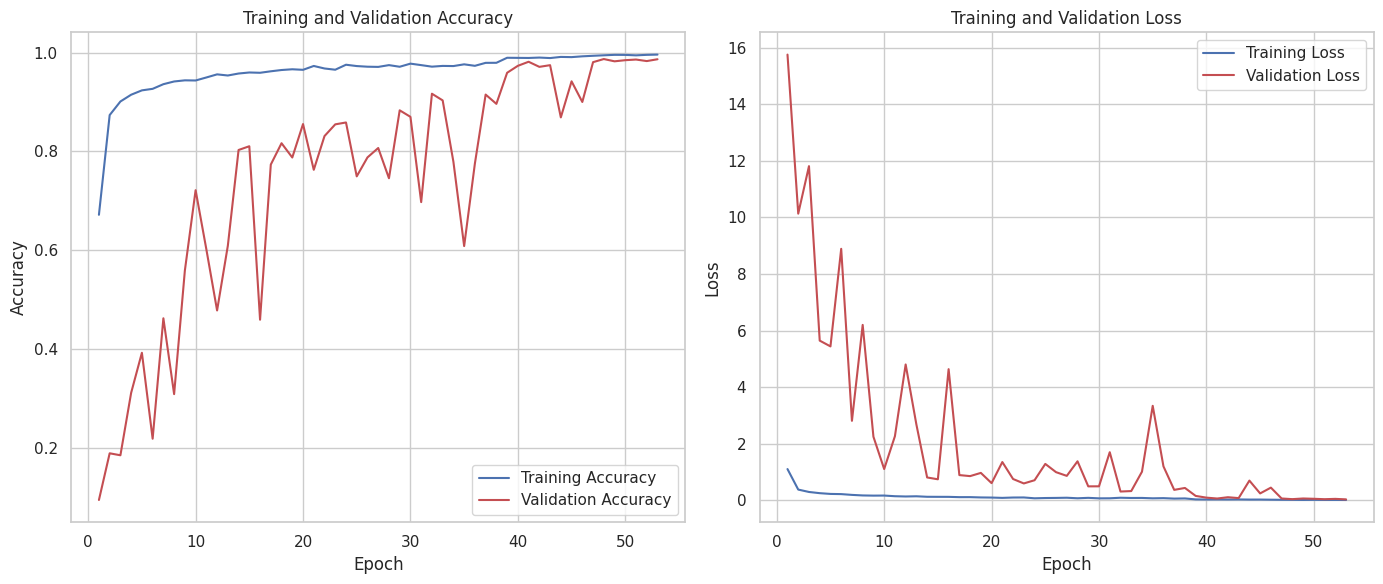

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from Epochs 1 to 53
data = [
    {"epoch": 1, "accuracy": 0.6716, "loss": 1.1051, "val_accuracy": 0.0943, "val_loss": 15.7593},
    {"epoch": 2, "accuracy": 0.8735, "loss": 0.3797, "val_accuracy": 0.1888, "val_loss": 10.1360},
    {"epoch": 3, "accuracy": 0.9010, "loss": 0.2951, "val_accuracy": 0.1848, "val_loss": 11.8151},
    {"epoch": 4, "accuracy": 0.9147, "loss": 0.2527, "val_accuracy": 0.3113, "val_loss": 5.6466},
    {"epoch": 5, "accuracy": 0.9235, "loss": 0.2261, "val_accuracy": 0.3923, "val_loss": 5.4421},
    {"epoch": 6, "accuracy": 0.9266, "loss": 0.2195, "val_accuracy": 0.2183, "val_loss": 8.8924},
    {"epoch": 7, "accuracy": 0.9360, "loss": 0.1919, "val_accuracy": 0.4621, "val_loss": 2.8109},
    {"epoch": 8, "accuracy": 0.9415, "loss": 0.1724, "val_accuracy": 0.3086, "val_loss": 6.2022},
    {"epoch": 9, "accuracy": 0.9438, "loss": 0.1659, "val_accuracy": 0.5587, "val_loss": 2.2488},
    {"epoch": 10, "accuracy": 0.9435, "loss": 0.1683, "val_accuracy": 0.7214, "val_loss": 1.1060},
    {"epoch": 11, "accuracy": 0.9496, "loss": 0.1450, "val_accuracy": 0.6018, "val_loss": 2.2661},
    {"epoch": 12, "accuracy": 0.9559, "loss": 0.1355, "val_accuracy": 0.4780, "val_loss": 4.8027},
    {"epoch": 13, "accuracy": 0.9536, "loss": 0.1427, "val_accuracy": 0.6089, "val_loss": 2.6796},
    {"epoch": 14, "accuracy": 0.9576, "loss": 0.1248, "val_accuracy": 0.8028, "val_loss": 0.8081},
    {"epoch": 15, "accuracy": 0.9597, "loss": 0.1233, "val_accuracy": 0.8104, "val_loss": 0.7434},
    {"epoch": 16, "accuracy": 0.9591, "loss": 0.1223, "val_accuracy": 0.4592, "val_loss": 4.6373},
    {"epoch": 17, "accuracy": 0.9621, "loss": 0.1119, "val_accuracy": 0.7733, "val_loss": 0.8920},
    {"epoch": 18, "accuracy": 0.9647, "loss": 0.1125, "val_accuracy": 0.8165, "val_loss": 0.8557},
    {"epoch": 19, "accuracy": 0.9662, "loss": 0.1017, "val_accuracy": 0.7876, "val_loss": 0.9696},
    {"epoch": 20, "accuracy": 0.9651, "loss": 0.0974, "val_accuracy": 0.8553, "val_loss": 0.6072},
    {"epoch": 21, "accuracy": 0.9729, "loss": 0.0863, "val_accuracy": 0.7627, "val_loss": 1.3533},
    {"epoch": 22, "accuracy": 0.9678, "loss": 0.0987, "val_accuracy": 0.8310, "val_loss": 0.7536},
    {"epoch": 23, "accuracy": 0.9653, "loss": 0.1010, "val_accuracy": 0.8547, "val_loss": 0.5965},
    {"epoch": 24, "accuracy": 0.9754, "loss": 0.0718, "val_accuracy": 0.8585, "val_loss": 0.7101},
    {"epoch": 25, "accuracy": 0.9727, "loss": 0.0810, "val_accuracy": 0.7494, "val_loss": 1.2869},
    {"epoch": 26, "accuracy": 0.9714, "loss": 0.0849, "val_accuracy": 0.7878, "val_loss": 0.9954},
    {"epoch": 27, "accuracy": 0.9710, "loss": 0.0913, "val_accuracy": 0.8068, "val_loss": 0.8641},
    {"epoch": 28, "accuracy": 0.9746, "loss": 0.0724, "val_accuracy": 0.7456, "val_loss": 1.3796},
    {"epoch": 29, "accuracy": 0.9713, "loss": 0.0874, "val_accuracy": 0.8831, "val_loss": 0.4934},
    {"epoch": 30, "accuracy": 0.9776, "loss": 0.0698, "val_accuracy": 0.8699, "val_loss": 0.4952},
    {"epoch": 31, "accuracy": 0.9746, "loss": 0.0718, "val_accuracy": 0.6973, "val_loss": 1.7011},
    {"epoch": 32, "accuracy": 0.9715, "loss": 0.0910, "val_accuracy": 0.9167, "val_loss": 0.3107},
    {"epoch": 33, "accuracy": 0.9730, "loss": 0.0830, "val_accuracy": 0.9032, "val_loss": 0.3270},
    {"epoch": 34, "accuracy": 0.9727, "loss": 0.0842, "val_accuracy": 0.7789, "val_loss": 1.0118},
    {"epoch": 35, "accuracy": 0.9762, "loss": 0.0708, "val_accuracy": 0.6083, "val_loss": 3.3408},
    {"epoch": 36, "accuracy": 0.9732, "loss": 0.0770, "val_accuracy": 0.7754, "val_loss": 1.2006},
    {"epoch": 37, "accuracy": 0.9792, "loss": 0.0609, "val_accuracy": 0.9150, "val_loss": 0.3699},
    {"epoch": 38, "accuracy": 0.9793, "loss": 0.0668, "val_accuracy": 0.8962, "val_loss": 0.4371},
    {"epoch": 39, "accuracy": 0.9895, "loss": 0.0323, "val_accuracy": 0.9591, "val_loss": 0.1553},
    {"epoch": 40, "accuracy": 0.9893, "loss": 0.0287, "val_accuracy": 0.9732, "val_loss": 0.0946},
    {"epoch": 41, "accuracy": 0.9891, "loss": 0.0301, "val_accuracy": 0.9814, "val_loss": 0.0636},
    {"epoch": 42, "accuracy": 0.9899, "loss": 0.0282, "val_accuracy": 0.9711, "val_loss": 0.1093},
    {"epoch": 43, "accuracy": 0.9889, "loss": 0.0308, "val_accuracy": 0.9745, "val_loss": 0.0785},
    {"epoch": 44, "accuracy": 0.9912, "loss": 0.0260, "val_accuracy": 0.8688, "val_loss": 0.6972},
    {"epoch": 45, "accuracy": 0.9908, "loss": 0.0266, "val_accuracy": 0.9418, "val_loss": 0.2439},
    {"epoch": 46, "accuracy": 0.9924, "loss": 0.0219, "val_accuracy": 0.9000, "val_loss": 0.4487},
    {"epoch": 47, "accuracy": 0.9935, "loss": 0.0183, "val_accuracy": 0.9806, "val_loss": 0.0646},
    {"epoch": 48, "accuracy": 0.9945, "loss": 0.0171, "val_accuracy": 0.9869, "val_loss": 0.0415},
    {"epoch": 49, "accuracy": 0.9954, "loss": 0.0132, "val_accuracy": 0.9823, "val_loss": 0.0647},
    {"epoch": 50, "accuracy": 0.9953, "loss": 0.0164, "val_accuracy": 0.9846, "val_loss": 0.0541},
    {"epoch": 51, "accuracy": 0.9944, "loss": 0.0135, "val_accuracy": 0.9859, "val_loss": 0.0394},
    {"epoch": 52, "accuracy": 0.9954, "loss": 0.0135, "val_accuracy": 0.9828, "val_loss": 0.0512},
    {"epoch": 53, "accuracy": 0.9959, "loss": 0.0119, "val_accuracy": 0.9865, "val_loss": 0.0329}
]

df = pd.DataFrame(data)

# Create subplots for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation accuracy
ax[0].plot(df['epoch'], df['accuracy'], label='Training Accuracy', color='b')
ax[0].plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy', color='r')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training and validation loss
ax[1].plot(df['epoch'], df['loss'], label='Training Loss', color='b')
ax[1].plot(df['epoch'], df['val_loss'], label='Validation Loss', color='r')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()
